In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

## 데이터 필드
id  - 생물의 ID

bone_length - 생물체의 뼈의 평균 길이. 0에서 1 사이의 정규화 된 값.

rotting_flesh  - 생물의 썩은 살의 비율

hair_length - 평균 머리 길이, 0에서 1 사이의 정규화

has_soul  - 생물체 내의 영혼의 비율

color - 지배적 인 색 : '흰색', '검은 색', '맑은', '푸른 색', '녹색', '피'

type  - 대상 변수 : 'Ghost', 'Goblin', 'Ghoul'

In [2]:
train.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost


In [3]:
test.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color
0,3,0.471774,0.387937,0.706087,0.698537,black
1,6,0.427332,0.645024,0.565558,0.451462,white
2,9,0.549602,0.491931,0.660387,0.449809,black
3,10,0.638095,0.682867,0.471409,0.356924,white
4,13,0.361762,0.583997,0.377256,0.276364,black


In [4]:
train = train.drop(['id'],axis=1)
test = test.drop(['id'],axis=1)

In [5]:
train.head()

,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,0.566117,0.875862,0.418594,0.636438,green,Ghost


In [6]:
test.head()

,bone_length,rotting_flesh,hair_length,has_soul,color
0,0.471774,0.387937,0.706087,0.698537,black
1,0.427332,0.645024,0.565558,0.451462,white
2,0.549602,0.491931,0.660387,0.449809,black
3,0.638095,0.682867,0.471409,0.356924,white
4,0.361762,0.583997,0.377256,0.276364,black


In [7]:
train.shape

(371, 6)

In [8]:
test.shape

(529, 5)

In [9]:
print(np.sort(train['color'].unique()))

['black' 'blood' 'blue' 'clear' 'green' 'white']


In [10]:
def chart(feature):
    ghoul = train[train['type']=='Ghoul'][feature].value_counts()
    goblin = train[train['type']=='Goblin'][feature].value_counts()
    ghost = train[train['type']=='Ghost'][feature].value_counts()
    df = pd.DataFrame([ghoul,goblin,ghost])
    df.index = ['Ghoul','Goblin','Ghost']
    df.plot(kind='bar',stacked=True, figsize=(10,5))

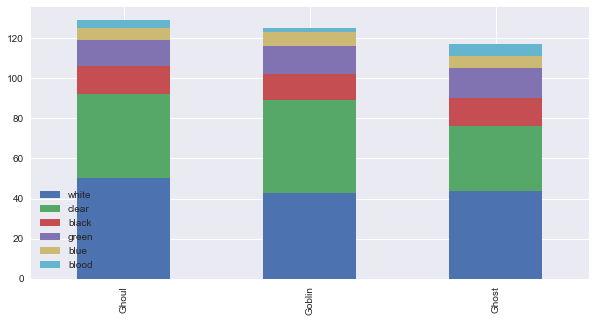

In [11]:
chart('color')

In [12]:
train = train.drop(['color'],axis=1)

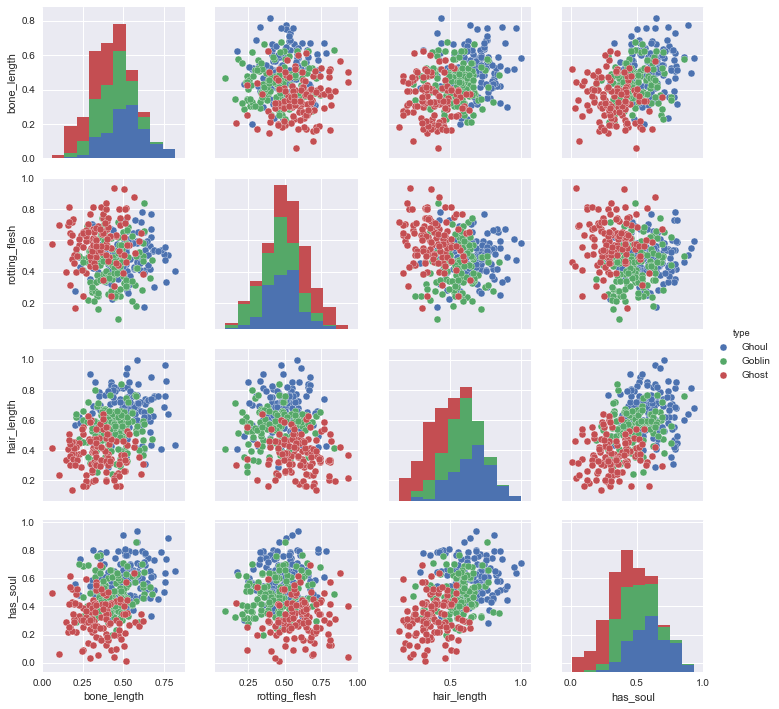

In [13]:
sns.pairplot(train,hue="type")

In [22]:
train['bl_rf'] = train.apply(lambda row: row['bone_length']+row['rotting_flesh'],axis=1)
train['bl_hl'] = train.apply(lambda row: row['bone_length']+row['hair_length'],axis=1)
train['bl_hs'] = train.apply(lambda row: row['bone_length']+row['has_soul'],axis=1)
train['rf_hl'] = train.apply(lambda row: row['rotting_flesh']+row['hair_length'],axis=1)
train['rf_hs'] = train.apply(lambda row: row['rotting_flesh']+row['has_soul'],axis=1)
train['hl_hs'] = train.apply(lambda row: row['hair_length']+row['has_soul'],axis=1)

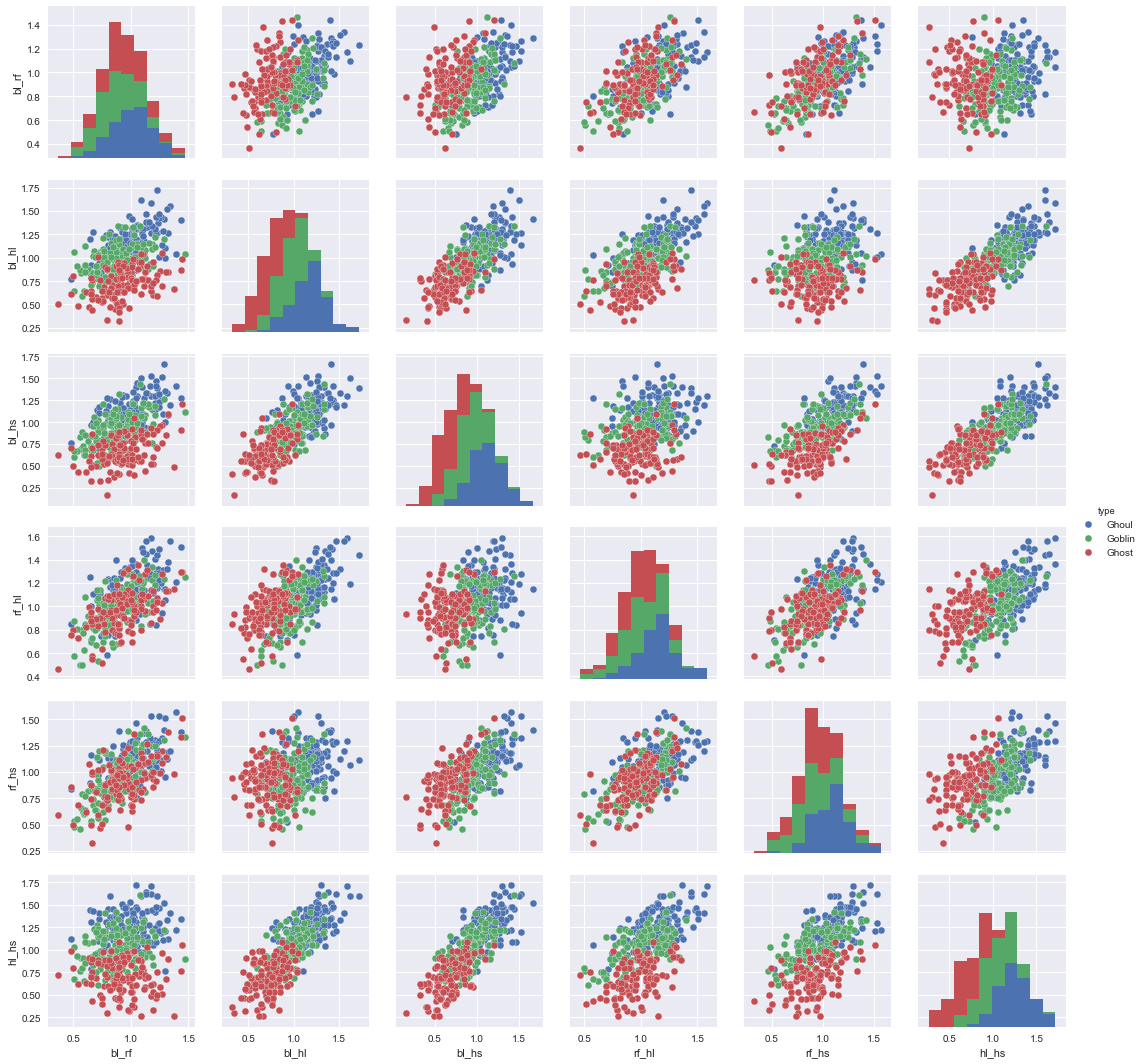

In [23]:
sns.set()
sns.pairplot(train[["bl_rf","bl_hl","bl_hs","rf_hl","rf_hs","hl_hs","type"]], hue="type")

In [24]:
train['bl_rf'] = train.apply(lambda row: row['bone_length']*row['rotting_flesh'],axis=1)
train['bl_hl'] = train.apply(lambda row: row['bone_length']*row['hair_length'],axis=1)
train['bl_hs'] = train.apply(lambda row: row['bone_length']*row['has_soul'],axis=1)
train['rf_hl'] = train.apply(lambda row: row['rotting_flesh']*row['hair_length'],axis=1)
train['rf_hs'] = train.apply(lambda row: row['rotting_flesh']*row['has_soul'],axis=1)
train['hl_hs'] = train.apply(lambda row: row['hair_length']*row['has_soul'],axis=1)

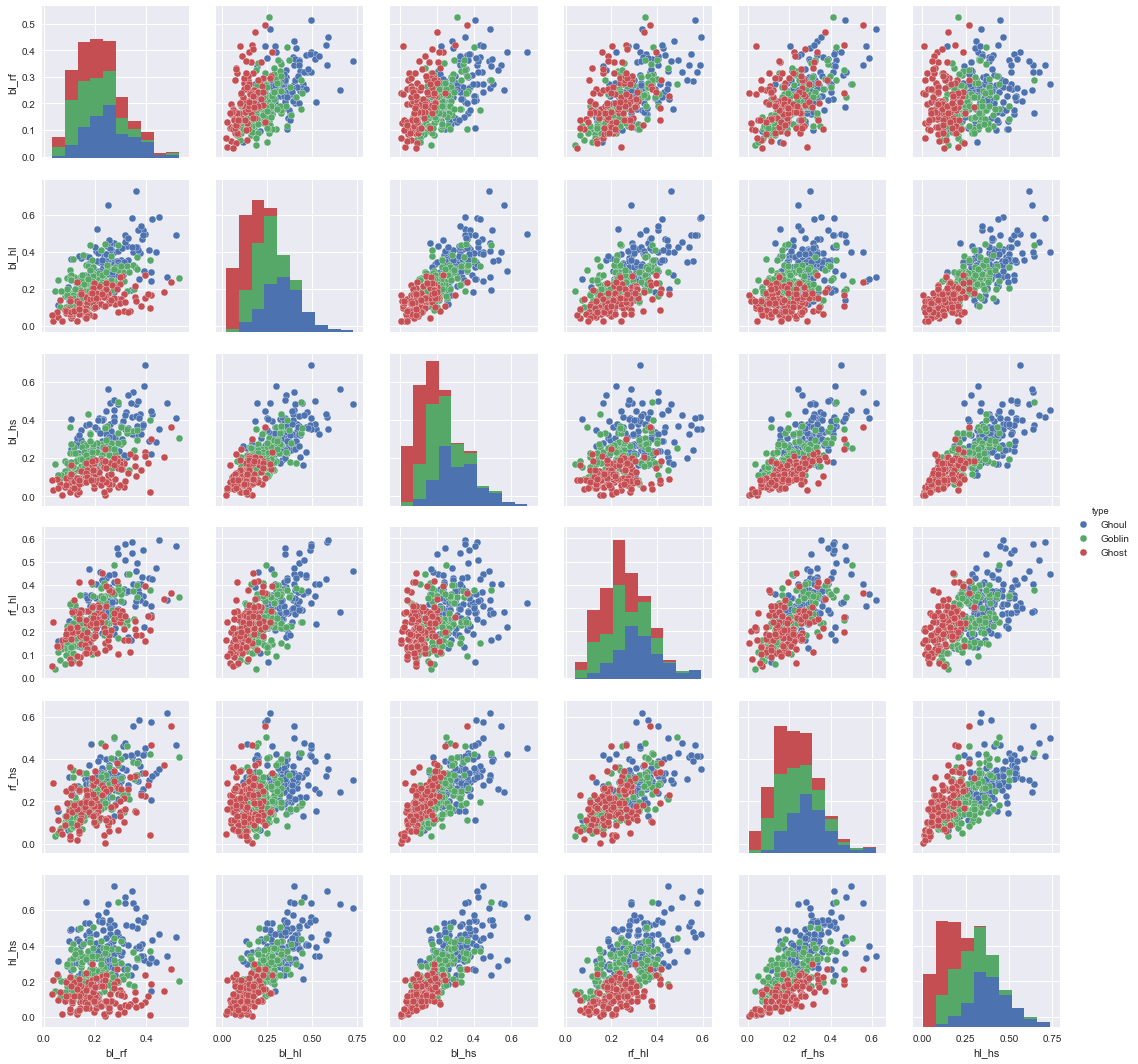

In [25]:
sns.set()
sns.pairplot(train[["bl_rf","bl_hl","bl_hs","rf_hl","rf_hs","hl_hs","type"]], hue="type")

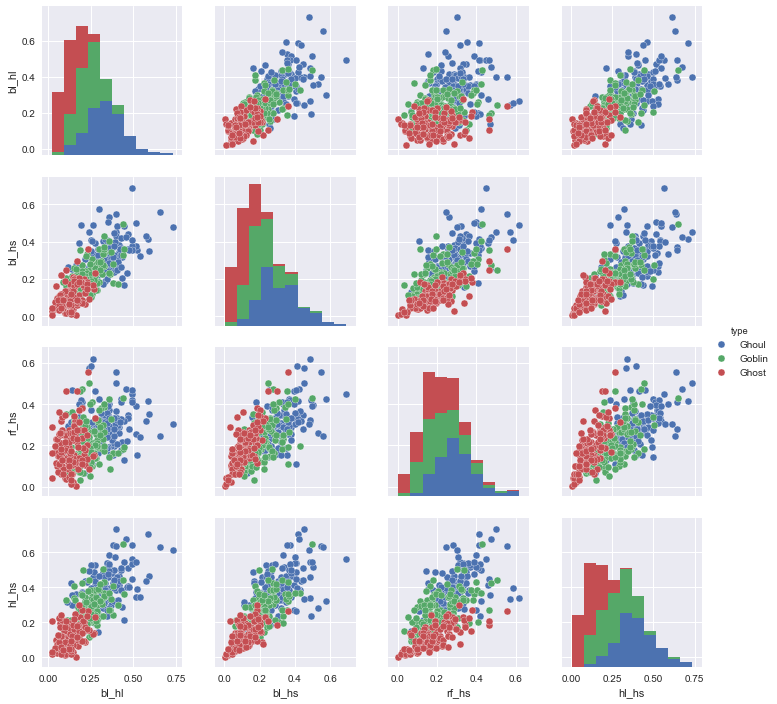

In [26]:
sns.set()
sns.pairplot(train[["bl_hl","bl_hs","rf_hs","hl_hs","type"]], hue="type")

In [27]:
"bl_hl","bl_hs","rf_hs","hl_hs","type"
train['bl_hl-bl_hs'] = train.apply(lambda row: row['bl_hl']*row['bl_hs'],axis=1)
train['bl_hl-rf_hs'] = train.apply(lambda row: row['bl_hl']*row['rf_hs'],axis=1)
train['bl_hl-hl_hs'] = train.apply(lambda row: row['bl_hl']*row['hl_hs'],axis=1)
train['bl_hs-rf_hs'] = train.apply(lambda row: row['bl_hs']*row['rf_hs'],axis=1)
train['bl_hs-hl_hs'] = train.apply(lambda row: row['bl_hs']*row['hl_hs'],axis=1)
train['rf_hs-hl_hs'] = train.apply(lambda row: row['rf_hs']*row['hl_hs'],axis=1)

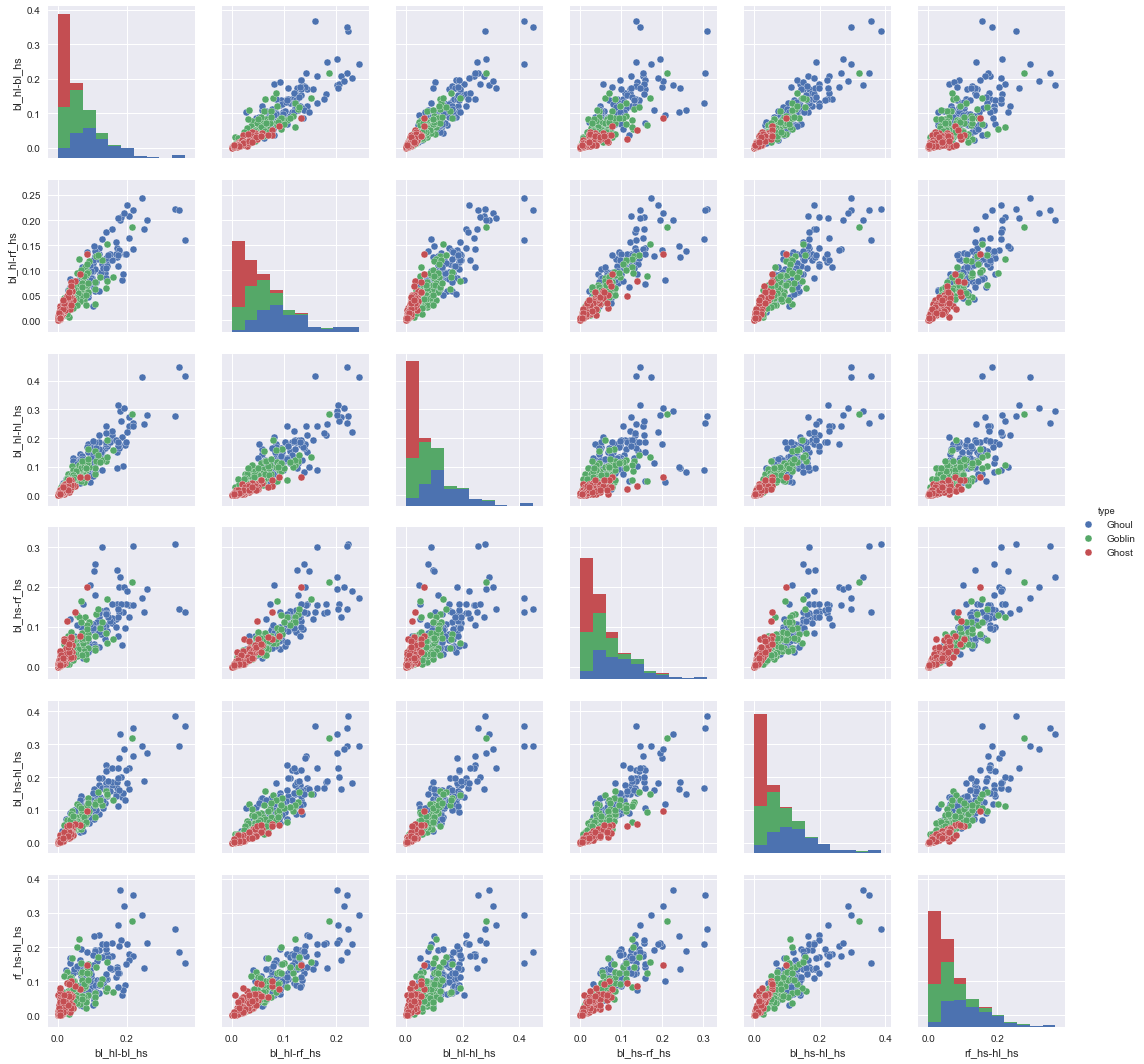

In [28]:
sns.set()
sns.pairplot(train[["bl_hl-bl_hs","bl_hl-rf_hs","bl_hl-hl_hs","bl_hs-rf_hs","bl_hs-hl_hs","rf_hs-hl_hs","type"]], hue="type")